## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

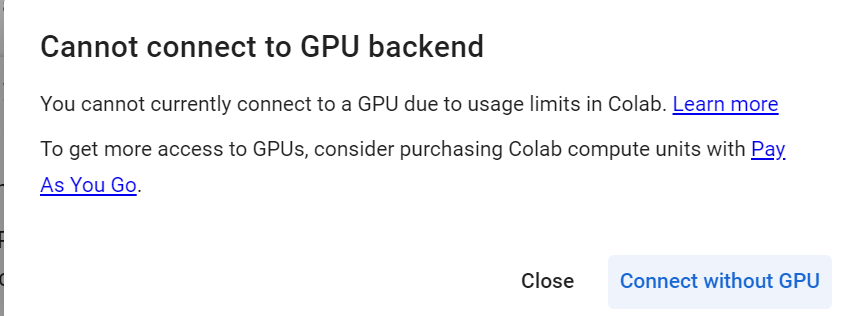

## **Installing and Importing Necessary Libraries**

In [11]:
!pip install -U python==3.11.7

ERROR: Could not find a version that satisfies the requirement python==3.11.7
ERROR: No matching distribution found for python==3.11.7


In [7]:
# Force reinstall compatible versions
!pip install -U python==3.11.7
!pip install -U "numpy>=1.26.0" "scikit-learn==1.3.2" "transformers==4.38.2" "sentence-transformers==2.2.2" "gensim==4.3.3" "xgboost==3.0.0"
# !pip install huggingface_hub==0.21.0
import numpy as np
np.__version__

ERROR: Could not find a version that satisfies the requirement numpy>=1.26.0
ERROR: No matching distribution found for numpy>=1.26.0


'1.22.4'

In [1]:
# Installing the libraries with the specified version.
# Uncomment and run the following line if Google Colab is being used
#!pip install -U sentence-transformers gensim transformers tqdm -q

# Install the required libraries
%pip install -U sentence-transformers gensim transformers tqdm -q

# Upgrade the click package to resolve the dependency conflict
%pip install click --upgrade

# Check the version of scikit-learn
import sklearn
print(sklearn.__version__)

# Reinstall scikit-learn if necessary
%pip install --upgrade scikit-learn

# To manipulate and analyze data
!pip install pandas
!pip install numpy
import pandas as pd
import numpy as np

# To visualize data
!pip install matplotlib
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)

!pip install xgboost 
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To suppress warnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
1.3.2



C:\Users\harit\anaconda3\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
stock_news_csv_path = "C:/Users/harit/OneDrive/Documents/PGP AIML University Of Texas/NLP/Stock Market News Sentiment Analysis/stock_news.csv"
stanford_glove_model_path = "C:/Users/harit/OneDrive/Documents/PGP AIML University Of Texas/NLP/Stock Market News Sentiment Analysis/glove.6B.100d.txt.word2vec"

## **Loading the dataset**

In [3]:

# Load dataset.
stocknews_df_org = pd.read_csv(stock_news_csv_path)
stocknews_df = stocknews_df_org.copy()

## **Data Overview**

In [4]:
stocknews_df.shape

(349, 8)

In [5]:
stocknews_df.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [6]:
stocknews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [7]:
stocknews_df.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [8]:
stocknews_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,349.0,4.622923e+01,6.442817e+00,3.756750e+01,4.174000e+01,4.597500e+01,5.070750e+01,6.681750e+01
High,349.0,4.670046e+01,6.507321e+00,3.781750e+01,4.224500e+01,4.602500e+01,5.085000e+01,6.706250e+01
Low,349.0,4.574539e+01,6.391976e+00,3.730500e+01,4.148250e+01,4.564000e+01,4.977750e+01,6.586250e+01
Close,349.0,4.492632e+01,6.398338e+00,3.625413e+01,4.024691e+01,4.459692e+01,4.911079e+01,6.480523e+01
Volume,349.0,1.289482e+08,4.317031e+07,4.544800e+07,1.032720e+08,1.156272e+08,1.511252e+08,2.444392e+08
Label,349.0,-5.444126e-02,7.151192e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [9]:
stocknews_df.columns.tolist()

['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label']

In [10]:
stocknews_df.nunique()

Date       71
News      349
Open       70
High       70
Low        71
Close      71
Volume     71
Label       3
dtype: int64

In [11]:
stocknews_df.duplicated().sum()

0

In [12]:
stocknews_df["Date"] = pd.to_datetime(stocknews_df["Date"])
stocknews_df["Date"].dt.year.value_counts()

2019    349
Name: Date, dtype: int64

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

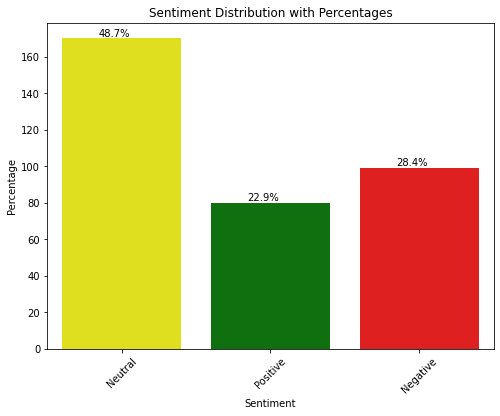

In [13]:
# Define the dataframes for each sentiment
stocknews_df = stocknews_df_org.copy()
stocknews_df = pd.DataFrame(stocknews_df)

# Create a mapping for the sentiment labels
sentiment_mapping = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}

# Map the sentiment labels to the DataFrame
stocknews_df['Label'] = stocknews_df['Label'].map(sentiment_mapping)

# Define a custom color palette
custom_palette = {'Neutral': 'yellow', 'Positive': 'green', 'Negative': 'red'}

# Create the countplot with custom labels and colors
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=stocknews_df, x="Label", order=['Neutral', 'Positive', 'Negative'], palette=custom_palette)

# Add percentage values to the countplot
total = len(stocknews_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Set plot labels and title
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Distribution with Percentages')

# Show the plot
plt.show()

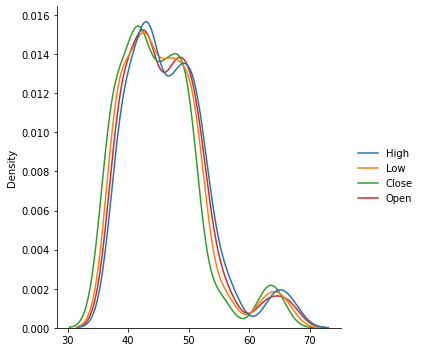

In [14]:
sns.displot(data=stocknews_df[['High','Low','Close','Open']], kind="kde", palette="tab10")

<Axes: xlabel='Volume', ylabel='Count'>

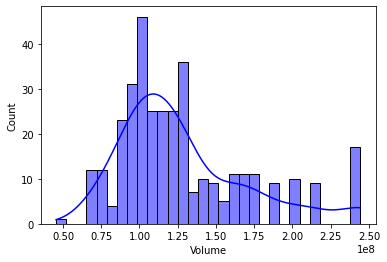

In [15]:
sns.histplot(stocknews_df, x='Volume', bins=30, kde=True, color='blue')

In [16]:
# Calculating the total number of words present in the news content.
stocknews_df['news_len'] = stocknews_df['News'].apply(lambda x: len(x.split(' ')))

# Displaying the statistics of the news length.
stocknews_df['news_len'].describe().T

count    349.000000
mean      49.312321
std        5.727770
min       19.000000
25%       46.000000
50%       50.000000
75%       53.000000
max       61.000000
Name: news_len, dtype: float64

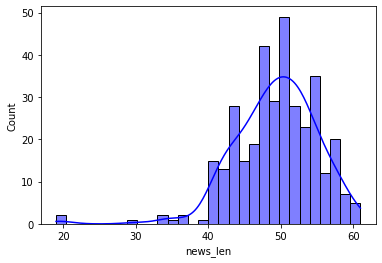

In [17]:
# Histogram of news_len column
sns.histplot(data=stocknews_df,x="news_len",kde=True,bins=30,color='blue',);

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

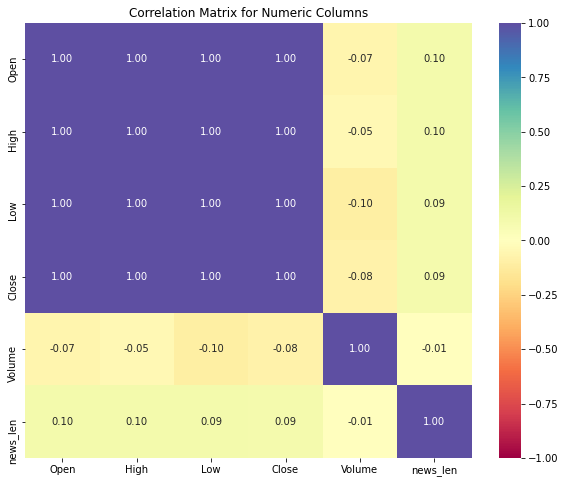

In [18]:
# Select only the numeric columns from the stocknews_df DataFrame
numeric_columns = stocknews_df.select_dtypes(include='number')

# Plot the correlation matrix fir the numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(
    numeric_columns.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)

# Set plot labels and title
plt.title('Correlation Matrix for Numeric Columns')
plt.show()

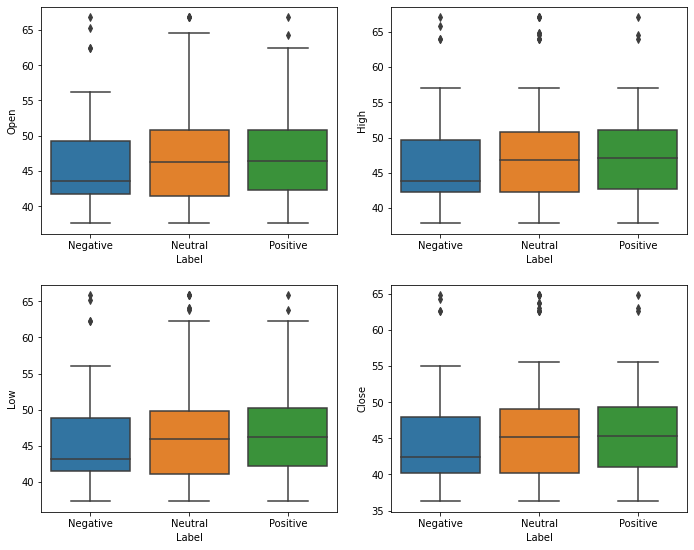

In [19]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stocknews_df, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

<Axes: xlabel='Label', ylabel='Volume'>

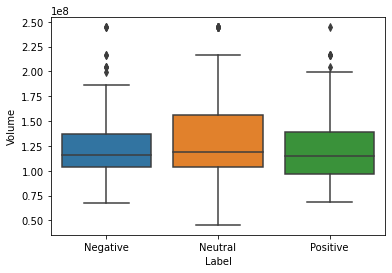

In [20]:
# Boxplot of Label vs Volume
sns.boxplot(
    data=stocknews_df, x="Label", y="Volume"
)

In [21]:
stock_daily = stocknews_df.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600


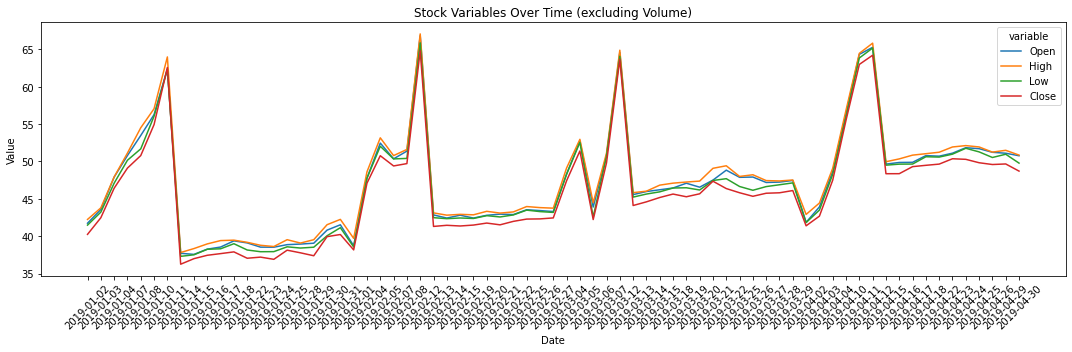

In [22]:
# Lineplot of all the variables except Volume
plt.figure(figsize=(15,5))
# sns.lineplot(stock_daily.drop("Volume", axis=1));

# Convert wide format to long format for plotting
melted_df = stock_daily.drop("Volume", axis=1).reset_index().melt(id_vars="Date")

# Plot
sns.lineplot(data=melted_df, x="Date", y="value", hue="variable")
plt.title("Stock Variables Over Time (excluding Volume)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

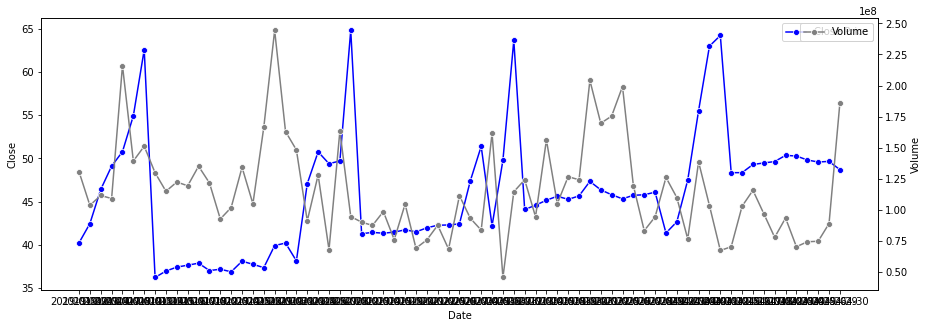

In [23]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## **Data Preprocessing**

In [24]:
# Statistical summary of the 'Date' column
stocknews_df["Date"].describe()

count            349
unique            71
top       2019-01-03
freq              28
Name: Date, dtype: object

In [25]:
# Ensure the 'Date' column is in datetime format
stocknews_df['Date'] = pd.to_datetime(stocknews_df['Date'])

# Extract relevant date components for summarization
stocknews_df['Year'] = stocknews_df['Date'].dt.year
stocknews_df['Month'] = stocknews_df['Date'].dt.month
stocknews_df['Day'] = stocknews_df['Date'].dt.day

# Print the statistical summary of the 'Date' column components
print("Year Summary:")
print(stocknews_df['Year'].describe())
print("\nMonth Summary:")
print(stocknews_df['Month'].describe())
print("\nDay Summary:")
print(stocknews_df['Day'].describe())

Year Summary:
count     349.0
mean     2019.0
std         0.0
min      2019.0
25%      2019.0
50%      2019.0
75%      2019.0
max      2019.0
Name: Year, dtype: float64

Month Summary:
count    349.000000
mean       2.077364
std        1.177997
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Month, dtype: float64

Day Summary:
count    349.000000
mean      15.389685
std        9.351840
min        1.000000
25%        6.000000
50%       15.000000
75%       24.000000
max       31.000000
Name: Day, dtype: float64


In [26]:
# Select all rows where the 'Date' is before '2019-04-01'
X_train = stocknews_df[(stocknews_df['Date'] < '2019-04-01')].reset_index()

# Select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_val = stocknews_df[(stocknews_df['Date'] >= '2019-04-01') & (stocknews_df['Date'] < '2019-04-16')].reset_index()

# Select all rows where the 'Date' is from '2019-04-16' till the end.
X_test = stocknews_df[stocknews_df['Date'] >= '2019-04-16'].reset_index()

# Set 'Label' column as the target variable
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

# Complete the code to print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("Train data shape: ",X_train.shape)
print("Validation data shape: ",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape: ",y_train.shape)
print("Validation label shape: ",y_val.shape)
print("Test label shape: ",y_test.shape)

Train data shape:  (286, 13)
Validation data shape:  (21, 13)
Test data shape  (42, 13)
Train label shape:  (286,)
Validation label shape:  (21,)
Test label shape:  (42,)


In [27]:
X_train.head()

,index,Date,News,Open,High,Low,Close,Volume,Label,news_len,Year,Month,Day
0,0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,Negative,46,2019,1,2
1,1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,Negative,51,2019,1,2
2,2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,Negative,49,2019,1,2
3,3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,Negative,51,2019,1,2
4,4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,Negative,50,2019,1,2


In [28]:
X_val.head()

,index,Date,News,Open,High,Low,Close,Volume,Label,news_len,Year,Month,Day
0,286,2019-04-02,"Apple and other consumer brands, including LV...",41.852501,42.915001,41.8200,41.390125,125982000,Neutral,45,2019,4,2
1,287,2019-04-02,Swatch Group successfully defended its use of...,41.852501,42.915001,41.8200,41.390125,125982000,Neutral,47,2019,4,2
2,288,2019-04-02,"In premarket trade Tuesday, Apple's NASDAQ AA...",41.852501,42.915001,41.8200,41.390125,125982000,Neutral,35,2019,4,2
3,289,2019-04-02,"In US markets, futures for the Dow, S&P 500, ...",41.852501,42.915001,41.8200,41.390125,125982000,Negative,47,2019,4,2
4,290,2019-04-03,"Japan Display, a key Apple supplier, is set t...",43.922501,44.437500,43.4925,42.684212,109744800,Positive,56,2019,4,3


In [29]:
X_test.head()

,index,Date,News,Open,High,Low,Close,Volume,Label,news_len,Year,Month,Day
0,307,2019-04-16,"In a complex trial in San Diego, Apple accuse...",49.865002,50.342499,49.639999,48.364113,102785600,Neutral,54,2019,4,16
1,308,2019-04-17,"Taiwan business tycoon Terry Gou, chairman of...",49.884998,50.845001,49.652500,49.305897,115627200,Neutral,44,2019,4,17
2,309,2019-04-17,"Chinese video-sharing app TikTok, owned by By...",49.884998,50.845001,49.652500,49.305897,115627200,Neutral,52,2019,4,17
3,310,2019-04-17,"TomTom, a Dutch navigation and digital maps f...",49.884998,50.845001,49.652500,49.305897,115627200,Positive,48,2019,4,17
4,311,2019-04-17,"In a volatile trading session, the S&P 500 wa...",49.884998,50.845001,49.652500,49.305897,115627200,Positive,49,2019,4,17


In [30]:
y_train.head()

0    Negative
1    Negative
2    Negative
3    Negative
4    Negative
Name: Label, dtype: object

In [31]:
y_val.head()

0     Neutral
1     Neutral
2     Neutral
3    Negative
4    Positive
Name: Label, dtype: object

In [32]:
y_test.head()

0     Neutral
1     Neutral
2     Neutral
3    Positive
4    Positive
Name: Label, dtype: object

## **Word Embeddings**

In [33]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stocknews_df['News'].values]

# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [34]:
# Checking the size of the vocabulary
print("Length of the vocabulary is ", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is  4682


In [35]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 3.14247678e-03,  4.41345610e-02,  5.58337709e-03,  2.40956694e-02,
       -2.99424003e-03, -5.07796742e-02,  3.51679362e-02,  8.44480917e-02,
        9.74577479e-03, -1.54191386e-02,  1.15568843e-02, -2.22787093e-02,
        1.38308306e-03,  1.20870322e-02, -2.95233652e-02, -2.52268147e-02,
        2.10632086e-02, -1.25814145e-02, -2.44270684e-03, -1.35594131e-02,
       -2.67193038e-02,  2.84449407e-03,  3.72547619e-02,  7.47858454e-03,
        1.47119034e-02,  6.11580256e-03, -4.40473780e-02,  6.36858912e-03,
       -1.84402205e-02, -3.53064947e-02,  1.39860222e-02, -2.16801353e-02,
        3.68177285e-03, -2.83461413e-03, -4.65351343e-03,  1.69364605e-02,
        1.72785781e-02, -3.82685214e-02,  1.91923161e-03, -1.04272384e-02,
       -1.62239913e-02, -1.59526721e-03, -1.76864152e-03, -2.64779981e-02,
        1.58872642e-02,  4.01073173e-02,  1.81149720e-04,  1.03981979e-02,
       -1.70715060e-03,  2.73568109e-02,  2.02999953e-02,  5.37354918e-03,
       -1.66075062e-02,  

In [36]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 3.14247678e-03,  4.41345610e-02,  5.58337709e-03,  2.40956694e-02,
       -2.99424003e-03, -5.07796742e-02,  3.51679362e-02,  8.44480917e-02,
        9.74577479e-03, -1.54191386e-02,  1.15568843e-02, -2.22787093e-02,
        1.38308306e-03,  1.20870322e-02, -2.95233652e-02, -2.52268147e-02,
        2.10632086e-02, -1.25814145e-02, -2.44270684e-03, -1.35594131e-02,
       -2.67193038e-02,  2.84449407e-03,  3.72547619e-02,  7.47858454e-03,
        1.47119034e-02,  6.11580256e-03, -4.40473780e-02,  6.36858912e-03,
       -1.84402205e-02, -3.53064947e-02,  1.39860222e-02, -2.16801353e-02,
        3.68177285e-03, -2.83461413e-03, -4.65351343e-03,  1.69364605e-02,
        1.72785781e-02, -3.82685214e-02,  1.91923161e-03, -1.04272384e-02,
       -1.62239913e-02, -1.59526721e-03, -1.76864152e-03, -2.64779981e-02,
        1.58872642e-02,  4.01073173e-02,  1.81149720e-04,  1.03981979e-02,
       -1.70715060e-03,  2.73568109e-02,  2.02999953e-02,  5.37354918e-03,
       -1.66075062e-02,  

In [37]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

print("Length of the dictionary is ", len(word_vector_dict))

Length of the dictionary is  4682


In [38]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [39]:
# Creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.5246882438659668


In [40]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


In [41]:
# Load the Stanford GloVe model
filename = stanford_glove_model_path
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [42]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [43]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [44]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [45]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [46]:
vec_size=100

In [47]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [48]:
# Creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)]) #Complete the code to apply GloVe on 'News' column

end = time.time()
print('Time taken ', (end-start))

Time taken  23.32537317276001


In [49]:
# Print the shapes of the final dataframes
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


In [50]:
# Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [51]:
# Setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

Using device: cpu


In [52]:
# Encoding the dataset
start = time.time()

# Apply Sentence Transformer on 'News' column
X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)

# Apply Sentence Transformer on 'News' column
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)

# Apply Sentence Transformer on 'News' column
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  3.1484463214874268


In [53]:
# Print the shapes of the final dataframes
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**

In [54]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [55]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

In [56]:
# Building the model

#base_wv = GradientBoostingClassifier(random_state=42)
#base_wv = RandomForestClassifier(random_state=42)
#base_wv = DecisionTreeClassifier(random_state=42)

from sklearn.ensemble import AdaBoostClassifier
base_wv = AdaBoostClassifier(random_state=42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

AdaBoostClassifier(random_state=42)

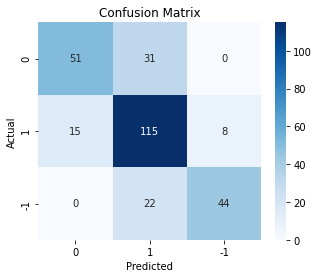

In [57]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

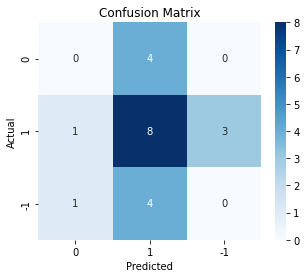

In [58]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [59]:
# Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.734266  0.734266   0.747112  0.732375


In [60]:
# Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.285714  0.326531


In [61]:
# Building the model

#base_gl = GradientBoostingClassifier(random_state=42)
#base_gl = RandomForestClassifier(random_state=42)
#base_gl = DecisionTreeClassifier(random_state=42)

from sklearn.ensemble import AdaBoostClassifier
base_gl = AdaBoostClassifier(random_state=42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train) #Complete the code to fit the chosen model on the train data

AdaBoostClassifier(random_state=42)

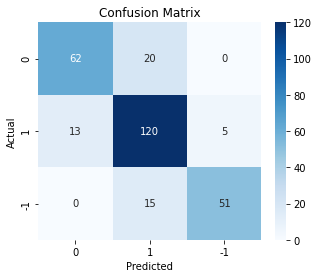

In [62]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(base_gl,X_train_gl,y_train)

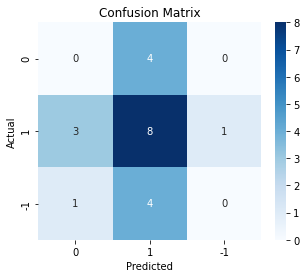

In [63]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(base_gl,X_val_gl,y_val)

In [64]:
# Calculating different metrics on training data

# Compute the model performance for the training data
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.814685  0.814685   0.820743  0.814623


In [65]:
# Calculating different metrics on validation data

# Compute the model performance for the validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.285714  0.326531


In [66]:
# Building the model

#base_st = GradientBoostingClassifier(random_state=42)
#base_st = RandomForestClassifier(random_state=42)
#base_st = DecisionTreeClassifier(random_state=42)

from sklearn.ensemble import AdaBoostClassifier
base_st = AdaBoostClassifier(random_state=42)

# Fitting on train data
base_st.fit(X_train_st, y_train) #Complete the code to fit the chosen model on the train data

AdaBoostClassifier(random_state=42)

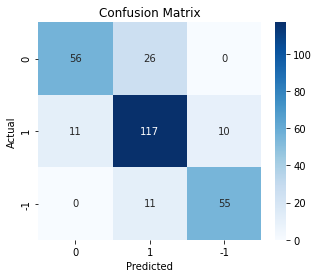

In [67]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(base_st,X_train_st,y_train)

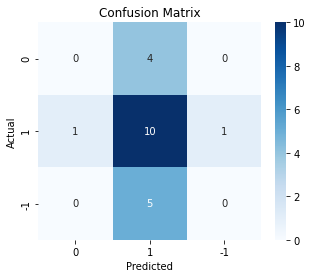

In [68]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(base_st,X_val_st,y_val)

In [69]:
# Calculating different metrics on training data

# Compute the model performance for the training data
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.797203  0.797203   0.801495  0.795967


In [70]:
#Calculating different metrics on validation data

# Compute the model performance for the validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.300752  0.368664


In [71]:
start = time.time()

# Choose the type of classifier.

#tuned_wv = GradientBoostingClassifier(random_state=42)
#tuned_wv = RandomForestClassifier(random_state=42)
#tuned_wv = DecisionTreeClassifier(random_state=42)

from sklearn.ensemble import AdaBoostClassifier
tuned_wv = AdaBoostClassifier(random_state=42)

parameters = {
#    'max_depth': np.arange(3,7),
#    'min_samples_split': np.arange(5,12,2),
#    'max_features': ['log2', 'sqrt', 0.2, 0.4]
#}

# AdaBoostClassifier parameters
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  21.709903955459595


In [72]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

AdaBoostClassifier(random_state=42)

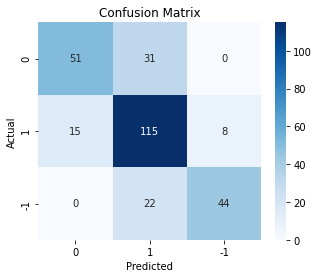

In [73]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

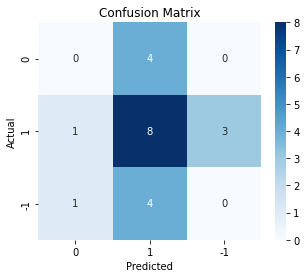

In [74]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [75]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.734266  0.734266   0.747112  0.732375


In [76]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.285714  0.326531


In [77]:
start = time.time()

#tuned_gl = GradientBoostingClassifier(random_state=42)
#tuned_gl = RandomForestClassifier(random_state=42)
#tuned_gl = DecisionTreeClassifier(random_state=42)

from sklearn.ensemble import AdaBoostClassifier
tuned_gl = AdaBoostClassifier(random_state=42)

parameters = {
#    'max_depth': np.arange(3,7),
#    'min_samples_split': np.arange(5,12,2),
#    'max_features': ['log2', 'sqrt', 0.2, 0.4]
#}

# AdaBoostClassifier parameters
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Run the grid search

# Complete the code to pass the chosen model, parameters, scoring metric, and number of
# cross-validation folds to GridSearchCV
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  7.860718250274658


In [78]:
# Fit the best algorithm to the data.

# Fit the chosen model on the train data
tuned_gl.fit(X_train_gl, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

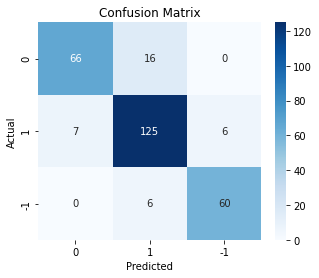

In [79]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

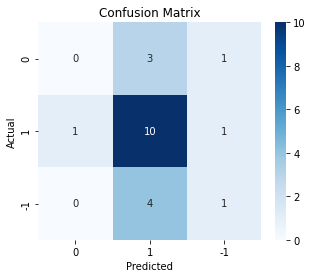

In [80]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [81]:
#Calculating different metrics on training data

# Compute the model performance for the training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision       F1
0  0.877622  0.877622   0.879314  0.87722


In [82]:
#Calculating different metrics on validation data

# Compute the model performance for the validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381     0.4155  0.453612


In [83]:
start = time.time()

# Choose the type of classifier.

#tuned_st = GradientBoostingClassifier(random_state=42)
#tuned_st = RandomForestClassifier(random_state=42)
#tuned_st = DecisionTreeClassifier(random_state=42)

from sklearn.ensemble import AdaBoostClassifier
tuned_st = AdaBoostClassifier(random_state=42)

parameters = {
#    'max_depth': np.arange(3,7),
#    'min_samples_split': np.arange(5,12,2),
#    'max_features': ['log2', 'sqrt', 0.2, 0.4]
#}

# AdaBoostClassifier parameters
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Run the grid search

#Complete the code to pass the chosen model
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  29.19498586654663


In [84]:
# Fit the best algorithm to the data.

# Fit the chosen model on the train data
tuned_st.fit(X_train_st, y_train)

AdaBoostClassifier(n_estimators=200, random_state=42)

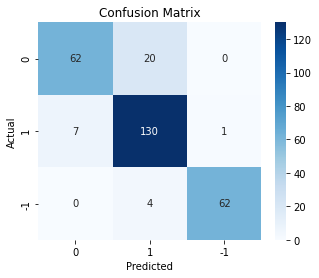

In [85]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(tuned_st,X_train_st,y_train)

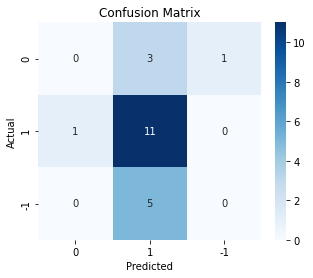

In [86]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [87]:
#Calculating different metrics on training data

# Compute the model performance for the training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy    Recall  Precision       F1
0  0.888112  0.888112   0.892053  0.88691


In [88]:
#Calculating different metrics on validation data

# Compute the model performance for the validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision       F1
0   0.52381  0.52381   0.330827  0.40553


In [89]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.734266,0.814685,0.797203,0.734266,0.877622,0.888112
Recall,0.734266,0.814685,0.797203,0.734266,0.877622,0.888112
Precision,0.747112,0.820743,0.801495,0.747112,0.879314,0.892053
F1,0.732375,0.814623,0.795967,0.732375,0.877220,0.886910


In [90]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.380952,0.380952,0.476190,0.380952,0.523810,0.523810
Recall,0.380952,0.380952,0.476190,0.380952,0.523810,0.523810
Precision,0.285714,0.285714,0.300752,0.285714,0.415500,0.330827
F1,0.326531,0.326531,0.368664,0.326531,0.453612,0.405530


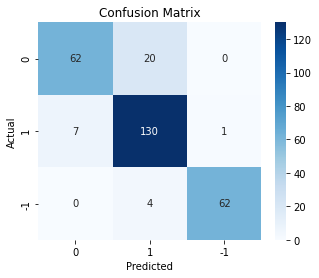

In [91]:
plot_confusion_matrix(tuned_st,X_train_st,y_train) #Complete the code to plot the confusion matrix for the final model and test data

In [92]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(tuned_st,X_train_st,y_train) #Complete the code to compute the final model's performance for the test data
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy    Recall  Precision       F1
0  0.888112  0.888112   0.892053  0.88691


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [97]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

'CMAKE_ARGS' is not recognized as an internal or external command,
operable program or batch file.


In [96]:
# Install llama-cpp-python if not already installed
%pip install llama-cpp-python

  Using cached llama_cpp_python-0.3.9.tar.gz (67.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
Failed to build llama-cpp-python
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\harit\anaconda3\python.exe' 'C:\Users\harit\anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' build_wheel 'C:\Users\harit\AppData\Local\Temp\tmp897_gvtp'
       cwd: C:\Users\harit\AppData\Local\Temp\pip-install-mcdaq74y\llama-cpp-python_df6eaaad1ba34a7992892f2906ed9068
  Complete output (312 lines):
  *** scikit-build-core 0.11.2 using CMake 4.0.2 (wheel)
  *** Configuring CMake...
  2025-05-11 16:56:03,577 - scikit_build_core - WARNING - Can't find a Python library, got libdir=None, ldlibrary=None, multiarch=None, masd=None
  loading initial cache file C:\Users\harit\AppData\Local\Temp\tmp1w4tebz6\build\CMakeInit.txt
  -- Building for: Visual Studio 15 2017
  -- Selecting Windows SDK version 10.0.22621.0 to target Windows 10.0.26100.
  -- The C compiler identification is MSVC 19.16.27054.0
  -- The CXX compiler identification is MSVC 19.16.27054.0
  -- Detecting C compiler ABI info
  -- Detecting C co

    ggml-threading.cpp
    gguf.cpp
    Generating Code...
  MakeDirsForLink:
    Creating directory "C:\Users\harit\AppData\Local\Temp\tmp1w4tebz6\build\vendor\llama.cpp\ggml\src\Release\".
  Link:
    C:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Tools\MSVC\14.16.27023\bin\HostX86\x64\link.exe /ERRORREPORT:QUEUE /OUT:"C:\Users\harit\AppData\Local\Temp\tmp1w4tebz6\build\bin\Release\ggml-base.dll" /INCREMENTAL:NO /NOLOGO kernel32.lib user32.lib gdi32.lib winspool.lib shell32.lib ole32.lib oleaut32.lib uuid.lib comdlg32.lib advapi32.lib /MANIFEST /MANIFESTUAC:"level='asInvoker' uiAccess='false'" /manifest:embed /PDB:"C:/Users/harit/AppData/Local/Temp/tmp1w4tebz6/build/bin/Release/ggml-base.pdb" /SUBSYSTEM:CONSOLE /TLBID:1 /DYNAMICBASE /NXCOMPAT /IMPLIB:"C:/Users/harit/AppData/Local/Temp/tmp1w4tebz6/build/vendor/llama.cpp/ggml/src/Release/ggml-base.lib" /MACHINE:X64  /machine:x64 /DLL "ggml-base.dir\Release\ggml.obj"
    "ggml-base.dir\Release\ggml-alloc.obj"
    "ggm

    C:\Users\harit\AppData\Local\Temp\pip-install-mcdaq74y\llama-cpp-python_df6eaaad1ba34a7992892f2906ed9068\vendor\llama.cpp\ggml\src\ggml-cpu\ops.cpp(6558): error C2039: 'max': is not a member of 'std' [C:\Users\harit\AppData\Local\Temp\tmp1w4tebz6\build\vendor\llama.cpp\ggml\src\ggml-cpu.vcxproj]
    C:\Users\harit\AppData\Local\Temp\pip-install-mcdaq74y\llama-cpp-python_df6eaaad1ba34a7992892f2906ed9068\vendor\llama.cpp\ggml\src\ggml-cpu\ops.cpp(6558): error C2039: 'min': is not a member of 'std' [C:\Users\harit\AppData\Local\Temp\tmp1w4tebz6\build\vendor\llama.cpp\ggml\src\ggml-cpu.vcxproj]
    C:\Users\harit\AppData\Local\Temp\pip-install-mcdaq74y\llama-cpp-python_df6eaaad1ba34a7992892f2906ed9068\vendor\llama.cpp\ggml\src\ggml-cpu\ops.cpp(6558): error C3861: 'min': identifier not found [C:\Users\harit\AppData\Local\Temp\tmp1w4tebz6\build\vendor\llama.cpp\ggml\src\ggml-cpu.vcxproj]
    C:\Users\harit\AppData\Local\Temp\pip-install-mcdaq74y\llama-cpp-python_df6eaaad1ba34a7992892f290

In [95]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

ModuleNotFoundError: No module named 'llama_cpp'

#### Loading the data

In [ ]:
# Load dataset.
stock_news = pd.read_csv(stock_news_csv_path)
data = stock_news.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

try:
    model_path = hf_hub_download(
        repo_id=model_name_or_path,
        filename=model_basename
    )
    print(f"Model downloaded successfully and saved at {model_path}")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
#uncomment the below snippet of code if the runtime is connected to GPU.
#llm = Llama(
#    model_path=model_path, # Path to the model
#    n_gpu_layers=100, #Number of layers transferred to GPU
#    n_ctx=4500, #Context window
#)

In [ ]:
# uncomment and run the following code in case GPU is not being used

llm = Llama(
     model_path=model_path,
     n_ctx=4500, # Context window
     # Using MacBook Air M2 with 8-cores, using 4 cores for the task.
     n_cores=-4 # Number of CPU cores to use
)

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0.7, #Complete the code to set the value for temperature.
      top_p=0.9, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
news = data_1.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

In [ ]:
print("Columns in model_response_parsed:", data_1.columns)

In [ ]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

##### Checking the model output on the weekly data

In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

In [ ]:

data_1.head()

In [ ]:
data_1['Key Events'].head(5)

##### Formatting the model output

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

In [ ]:
print("Columns in model_response_parsed:", model_response_parsed.columns)

In [ ]:
model_response_parsed

In [ ]:
data_1.columns

In [ ]:
model_response_parsed.column

In [ ]:
model_response_parsed.head()

In [ ]:
data_1.columns

In [ ]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

In [ ]:
final_output

## **Conclusions and Recommendations**

-




<font size=6 color='blue'>Power Ahead</font>
___